In [1]:
from functions_for_all_nutrients import *
from vitamin_a_and_zinc_functions import *

In [2]:
# Get absolute path of repo based on relative directory structure,
# so it should work for all users
import os.path
vivarium_research_lsff_path = os.path.abspath("..")
vivarium_research_lsff_path

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/ihme/homes/ndbs/vivarium_research_lsff'

In [3]:
username = !whoami
username

['ndbs']

In [4]:
# Make shared directories in which to store GBD data so we don't have to keep calling `get_draws`

# Nathaniel has saved some .hdf files in this directory:
# You can change it if you save GBD data in a different directory.
read_share_dir = f'/share/scratch/users/ndbs/vivarium_lsff/gbd_data'

# GBD data will be stored here in an .hdf file if it doesn't exist in the directory above:
# You can change this directory name if you want, and you may need to create it before running code below.
write_share_dir = f'/share/scratch/users/{username[0]}/vivarium_lsff/gbd_data'

In [5]:
index_cols=['location_id','sex_id','age_group_id']
age_group_ids = [2,3,4,5]
sex_ids = [1,2]
coverage_levels = [0.2,0.5,0.8]
years = [2021,2022,2023,2024,2025]

In [6]:
coverage_data_dir = vivarium_research_lsff_path + '/data_prep/outputs/lsff_input_coverage_data.csv'
# # Old version that may not work for all users:
# coverage_data_dir = f'/ihme/homes/{username[0]}/notebooks/' \
#     'vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [7]:
location_ids = (list(
                pd.read_csv(coverage_data_dir)
                .location_id
                .unique()))
location_ids

[179, 163, 214, 161, 165, 190, 189, 196]

# VITAMIN A

In [8]:
# vitamin A specific -- these should be replaced for other models
rei_id = 96
nutrient = 'vitamin a'
vehicle = 'oil'
effective_fractions = [0, 0, (365 - (365 * 0.5)) / (365 - 28), 1]

In [9]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 2.22
q_975 = 5.26

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)b
rr_distribution = lognorm(s=sigma, scale=median)

In [10]:
vitamin_a_baseline_coverage, vitamin_a_counterfactual_coverage = generate_overall_coverage_rates(
                                                     coverage_data_dir,
                                                     nutrient, 
                                                     vehicle,
                                                     coverage_levels,
                                                     years,
                                                     location_ids,
                                                     ['under-5','total population',np.nan])

In [11]:
vitamin_a_baseline_effective_coverage = get_effective_vitamin_a_coverage(vitamin_a_baseline_coverage, 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)
vitamin_a_counterfactual_effective_coverage = get_effective_vitamin_a_coverage(vitamin_a_counterfactual_coverage, 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
vitamin_a_rr_deficiency_nofort = generate_rr_deficiency_nofort_draws(mu, sigma, location_ids)
vitamin_a_rr_deficiency_nofort.mean(axis=1)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


location_id
179    2.396239
163    2.396239
214    2.396239
161    2.396239
165    2.396239
190    2.396239
189    2.396239
196    2.396239
dtype: float64

In [13]:
# This key name should be updated when countries from other tiers are added:
vitamin_a_dalys_hdf_key = '/vitamin_a_deficiency/dalys_attributable_tier_1_2'
try:
    vitamin_a_dalys = pd.read_hdf(read_share_dir + '/multmodel_data.hdf', key=vitamin_a_dalys_hdf_key)
except (FileNotFoundError, KeyError) as e:
    print(e, "Calling get_draws...")
    vitamin_a_dalys = pull_deficiency_attributable_dalys(rei_id,
                                                  location_ids,
                                                  age_group_ids,
                                                  sex_ids,
                                                  index_cols)
    vitamin_a_dalys.to_hdf(write_share_dir + '/multmodel_data.hdf', key=vitamin_a_dalys_hdf_key)
vitamin_a_dalys.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


draw_0       draw_1      draw_10  \
location_id sex_id age_group_id                                          
161         1      2                7.070884     4.883704     3.926378   
                   3              139.727452   106.822754    66.430695   
                   4              893.447633  1057.681859   961.993856   
                   5             2863.462011  2188.485813  4092.841375   
            2      2                6.828921     4.566549     3.725324   

                                    draw_100     draw_101     draw_102  \
location_id sex_id age_group_id                                          
161         1      2                4.949767     2.268192     2.894838   
                   3              140.884393   105.038912    87.420484   
                   4              420.836896   285.419952   389.102293   
                   5             2258.573109  1891.710026  1815.305494   
            2      2                3.972724     3.358750     7.175186   

                                    draw_103     draw_104     draw_105  \
location_id sex_id age_group_id                                          
161         1      2                4.686611     1.631877     2.028275   
                   3              112.985095    87.411651   115.049557   
                   4              606.407734   939.415010  1155.526190   
                   5             1677.126362  2611.655148  2118.315967   
            2      2                2.007530     4.042930    10.275615   

                                    draw_106  ...     draw_990     draw_991  \
location_id sex_id age_group_id               ...                             
161         1      2                1.409405  ...     3.829381     8.500935   
                   3               51.456842  ...    77.524770   132.737442   
                   4              848.801492  ...   712.875641   883.660796   
                   5             4717.972653  ...  1566.419663  4280.439076   
            2      2                3.936950  ...     6.032157     2.129924   

                                    draw_992     draw_993     draw_994  \
location_id sex_id age_group_id                                          
161         1      2                3.995909     4.312142     1.482322   
                   3              106.388187    60.265158    80.067924   
                   4             1535.449452   904.694866  1239.880268   
                   5             3951.339992  3837.833649  2203.954969   
            2      2                2.403587     4.303640     4.903087   

                                    draw_995     draw_996     draw_997  \
location_id sex_id age_group_id                                          
161         1      2                2.890548     1.329123     2.769856   
                   3              495.950636    14.970979    59.344337   
                   4             1443.879777   519.918227   621.128099   
                   5             2130.155631  1865.487934  2505.819713   
            2      2                3.547450     1.852772     2.988300   

                                    draw_998     draw_999  
location_id sex_id age_group_id                            
161         1      2                5.735606     4.154093  
                   3               74.768423    25.927682  
                   4              518.036887   594.537913  
                   5             1749.988359  1895.672925  
            2      2                3.672954     0.762774  

[5 rows x 1000 columns]

In [14]:
vitamin_a_paf_deficiency_nofort = calculate_paf_deficiency_nofort(
                                    vitamin_a_rr_deficiency_nofort, 
                                    vitamin_a_baseline_effective_coverage)
vitamin_a_paf_deficiency_nofort.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


draw_0    draw_1   draw_10  draw_100  \
location_id sex_id age_group_id year                                          
161         1      2            2021  0.78595  0.447022  0.406811  0.340996   
                                2022  0.78595  0.447022  0.406811  0.340996   
                                2023  0.78595  0.447022  0.406811  0.340996   
                                2024  0.78595  0.447022  0.406811  0.340996   
                                2025  0.78595  0.447022  0.406811  0.340996   

                                      draw_101  draw_102  draw_103  draw_104  \
location_id sex_id age_group_id year                                           
161         1      2            2021  0.617978  0.620854  0.149863  0.636347   
                                2022  0.617978  0.620854  0.149863  0.636347   
                                2023  0.617978  0.620854  0.149863  0.636347   
                                2024  0.617978  0.620854  0.149863  0.636347   
                                2025  0.617978  0.620854  0.149863  0.636347   

                                      draw_105  draw_106  ...  draw_990  \
location_id sex_id age_group_id year                      ...             
161         1      2            2021  0.421241  0.759597  ...  0.507946   
                                2022  0.421241  0.759597  ...  0.507946   
                                2023  0.421241  0.759597  ...  0.507946   
                                2024  0.421241  0.759597  ...  0.507946   
                                2025  0.421241  0.759597  ...  0.507946   

                                      draw_991  draw_992  draw_993  draw_994  \
location_id sex_id age_group_id year                                           
161         1      2            2021  0.455066  0.740104  0.785748  0.396677   
                                2022  0.455066  0.740104  0.785748  0.396677   
                                2023  0.455066  0.740104  0.785748  0.396677   
                                2024  0.455066  0.740104  0.785748  0.396677   
                                2025  0.455066  0.740104  0.785748  0.396677   

                                      draw_995  draw_996  draw_997  draw_998  \
location_id sex_id age_group_id year                                           
161         1      2            2021  0.557149   0.64751  0.441514  0.406003   
                                2022  0.557149   0.64751  0.441514  0.406003   
                                2023  0.557149   0.64751  0.441514  0.406003   
                                2024  0.557149   0.64751  0.441514  0.406003   
                                2025  0.557149   0.64751  0.441514  0.406003   

                                      draw_999  
location_id sex_id age_group_id year            
161         1      2            2021  0.393076  
                                2022  0.393076  
                                2023  0.393076  
                                2024  0.393076  
                                2025  0.393076  

[5 rows x 1000 columns]

In [15]:
vitamin_a_pif_deficiency_nofort = calculate_pif_deficiency_nofort(
                                    vitamin_a_paf_deficiency_nofort,
                                    vitamin_a_baseline_effective_coverage,
                                    vitamin_a_counterfactual_effective_coverage)
vitamin_a_pif_deficiency_nofort.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


draw_0  draw_1  draw_10  \
location_id sex_id age_group_id year coverage_level                            
161         1      2            2021 0.2                0.0     0.0      0.0   
                                     0.5                0.0     0.0      0.0   
                                     0.8                0.0     0.0      0.0   
                                2022 0.2                0.0     0.0      0.0   
                                     0.5                0.0     0.0      0.0   

                                                     draw_100  draw_101  \
location_id sex_id age_group_id year coverage_level                       
161         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_102  draw_103  \
location_id sex_id age_group_id year coverage_level                       
161         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_104  draw_105  \
location_id sex_id age_group_id year coverage_level                       
161         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_106  ...  draw_990  \
location_id sex_id age_group_id year coverage_level            ...             
161         1      2            2021 0.2                  0.0  ...       0.0   
                                     0.5                  0.0  ...       0.0   
                                     0.8                  0.0  ...       0.0   
                                2022 0.2                  0.0  ...       0.0   
                                     0.5                  0.0  ...       0.0   

                                                     draw_991  draw_992  \
location_id sex_id age_group_id year coverage_level                       
161         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_993  draw_994  \
location_id sex_id age_group_id year coverage_level                       
161         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_995  draw_996  \
location_id sex_id age_group_id year coverage_level                       
161         1      2            2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
 

In [16]:
vitamin_a_overall_pifs, vitamin_a_daly_reduction_counts = calculate_final_pifs_and_daly_reductions(
                                                    vitamin_a_pif_deficiency_nofort,
                                                    vitamin_a_dalys,
                                                    coverage_levels, years)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
vitamin_a_daly_reduction_rates = calculate_rates(vitamin_a_daly_reduction_counts, 
                                            location_ids, 
                                            age_group_ids, 
                                            sex_ids)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
vitamin_a_overall_pifs['measure'] = 'pif'
vitamin_a_daly_reduction_counts['measure'] = 'counts_averted'
vitamin_a_daly_reduction_rates['measure'] = 'rates_averted'
vitamin_a_results = pd.concat([vitamin_a_overall_pifs.reset_index(),
                         vitamin_a_daly_reduction_counts.reset_index(),
                         vitamin_a_daly_reduction_rates.reset_index()],
                        ignore_index=True)
vitamin_a_results.to_pickle('results_raw/vitamin_a.pkl')

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


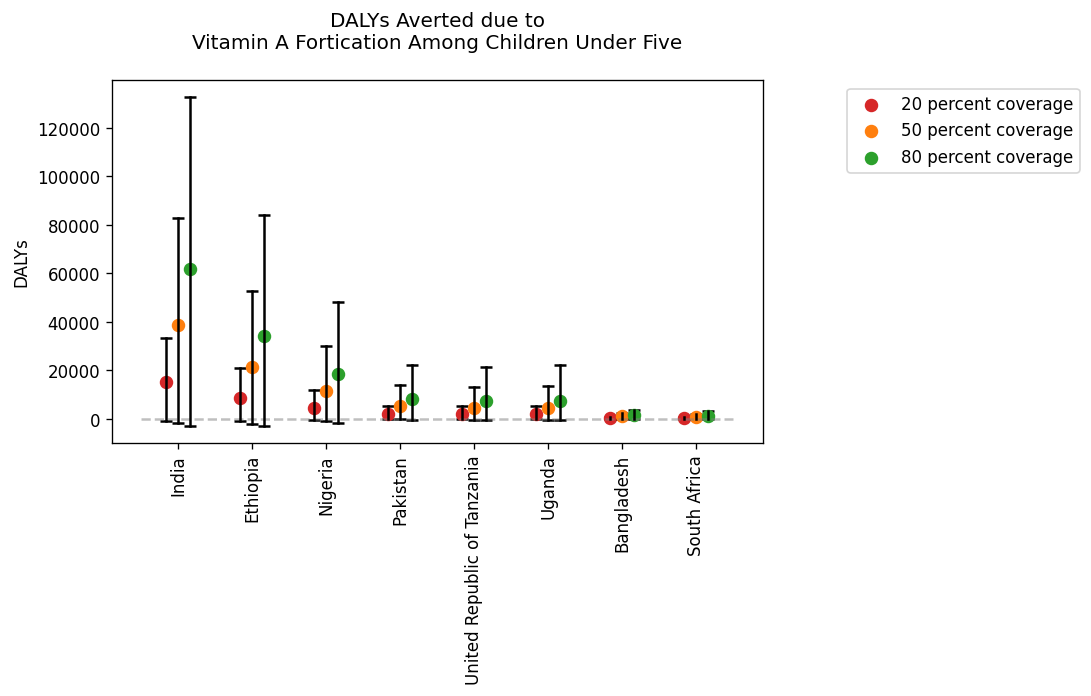

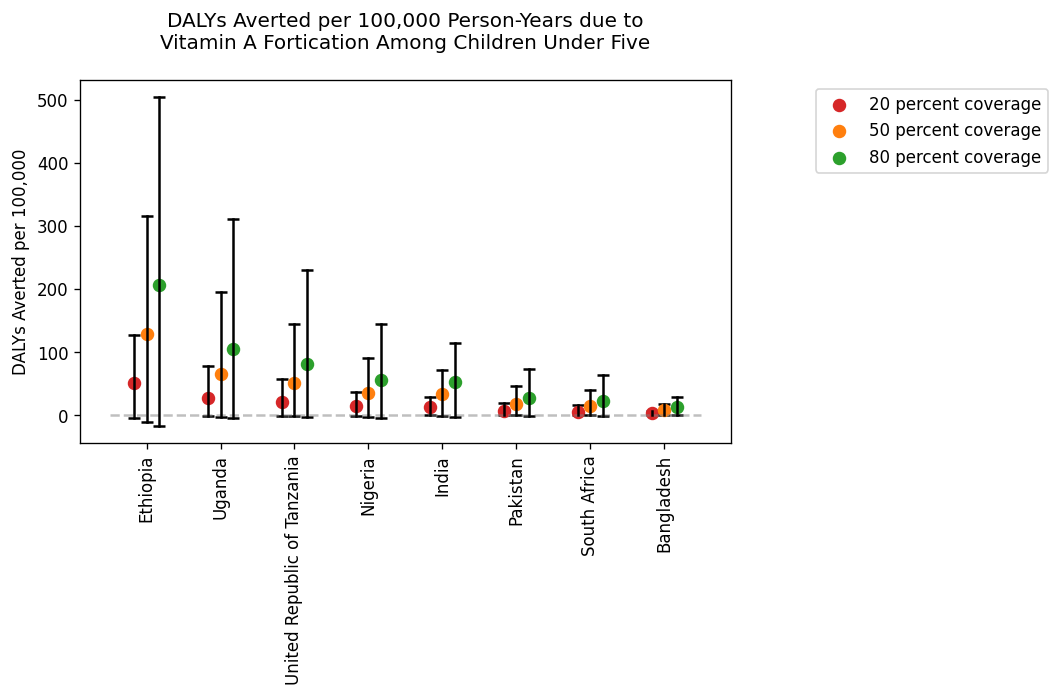

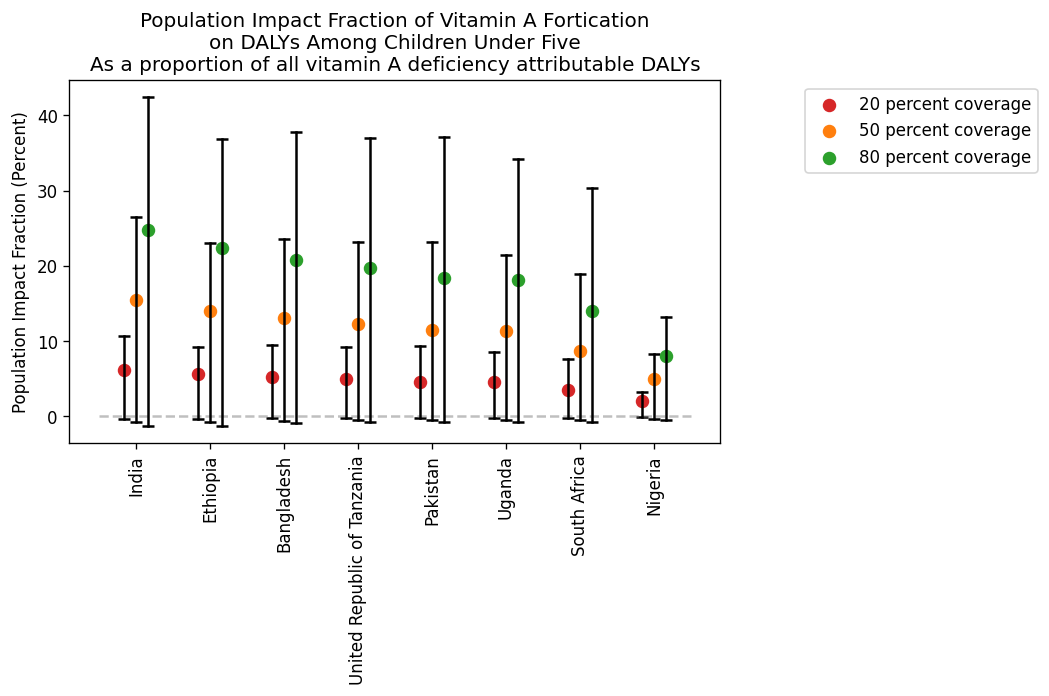

In [19]:
make_dot_plots(vitamin_a_daly_reduction_counts, 'Vitamin A', 'counts', coverage_levels, '', 'vitamin_a_u5_counts_averted')
make_dot_plots(vitamin_a_daly_reduction_rates, 'Vitamin A', 'rates', coverage_levels, '', 'vitamin_a_u5_rates_averted')
make_dot_plots(vitamin_a_overall_pifs, 'Vitamin A', 'pifs', coverage_levels, 
               'As a proportion of all vitamin A deficiency attributable DALYs',
              'vitamin_a_u5_pif')

# ZINC

In [20]:
# ZINC
rei_id = 97
nutrient = 'zinc'
vehicle = 'wheat flour'
effective_fractions = [0,0,0,1]

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 0.47
q_975 = 0.69

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)
rr_distribution = lognorm(s=sigma, scale=median)

In [22]:
zinc_baseline_coverage, zinc_counterfactual_coverage = generate_overall_coverage_rates(
                                                     coverage_data_dir,
                                                     nutrient, 
                                                     vehicle,
                                                     coverage_levels,
                                                     years,
                                                     location_ids,
                                                     ['under-5','total population',np.nan])

In [23]:
zinc_rr_deficiency_nofort = (1 / generate_rr_deficiency_nofort_draws(mu, sigma, location_ids))
zinc_rr_deficiency_nofort.mean(axis=1)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


location_id
179    2.178029
163    2.178029
214    2.178029
161    2.178029
165    2.178029
190    2.178029
189    2.178029
196    2.178029
dtype: float64

In [24]:
# This key name should be updated when countries from other tiers are added:
zinc_dalys_hdf_key = '/zinc_deficiency/dalys_attributable_tier_1_2'
try:
    zinc_dalys = pd.read_hdf(read_share_dir + '/multmodel_data.hdf', key=zinc_dalys_hdf_key)
except (FileNotFoundError, KeyError) as e:
    print(e, "Calling get_draws...")
    zinc_dalys = pull_deficiency_attributable_dalys(rei_id,
                                              location_ids,
                                              age_group_ids,
                                              sex_ids,
                                              index_cols)
    zinc_dalys.to_hdf(write_share_dir + '/multmodel_data.hdf', key=zinc_dalys_hdf_key)
zinc_dalys.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


draw_0        draw_1       draw_10  \
location_id sex_id age_group_id                                             
161         1      5               296.769109     74.453137    221.348018   
            2      5               327.587850    158.475789    134.827131   
163         1      5             16949.136066   5790.907117   7164.505392   
            2      5             17480.919921   8297.696257  12246.257864   
165         1      5             25484.105212  15971.752737  13576.008166   

                                     draw_100     draw_101     draw_102  \
location_id sex_id age_group_id                                           
161         1      5               351.983373   180.640379   116.430535   
            2      5               543.031190    86.444871   109.066272   
163         1      5             10037.163644  4544.152076  3212.868622   
            2      5             19603.059582  8975.319614  6112.236218   
165         1      5             28575.704766  8703.969447  7472.266857   

                                    draw_103      draw_104      draw_105  \
location_id sex_id age_group_id                                            
161         1      5               89.058635    358.929601    639.977786   
            2      5              172.648985    849.060903    354.823783   
163         1      5             5638.983711  19172.637650  12517.170514   
            2      5             7914.494521  22383.542155  22995.225388   
165         1      5             6241.642156  19134.859027  18679.004504   

                                     draw_106  ...      draw_990  \
location_id sex_id age_group_id                ...                 
161         1      5               310.348658  ...    432.487807   
            2      5               342.709307  ...    393.686361   
163         1      5             14340.011960  ...  15876.397913   
            2      5             10836.023177  ...  20254.952241   
165         1      5             22485.906851  ...  19442.330344   

                                     draw_991      draw_992      draw_993  \
location_id sex_id age_group_id                                             
161         1      5               463.977633    244.970937    403.311520   
            2      5               523.613383    432.241092    447.313429   
163         1      5             20739.827751  13920.518362  14662.124164   
            2      5             20685.013922  12564.264817  14298.015574   
165         1      5             26372.363235  20280.343230  30713.185813   

                                     draw_994      draw_995      draw_996  \
location_id sex_id age_group_id                                             
161         1      5               721.292922    654.274139    309.811501   
            2      5               495.995465    728.359661    703.717715   
163         1      5             26629.654957  22032.790274  14306.073292   
            2      5             38877.039385  16602.180202  15995.499287   
165         1      5             37788.351711  33040.283797  25793.909912   

                                     draw_997      draw_998      draw_999  
location_id sex_id age_group_id                                            
161         1      5               251.686322    175.636588    426.660064  
            2      5               527.254785    425.230960    612.545056  
163         1      5             13102.264170  10226.563640  10168.938426  
            2      5             13924.475543  11921.955400  12711.902860  
165         1      5             17059.275648  12930.266623  24044.162287  

[5 rows x 1000 columns]

In [25]:
zinc_baseline_effective_coverage = apply_age_related_effective_coverage_restrictions(
                                                                zinc_baseline_coverage,
                                                                sex_ids,
                                                                age_group_ids,
                                                                effective_fractions)
zinc_counterfactual_effective_coverage = apply_age_related_effective_coverage_restrictions(
                                                                zinc_counterfactual_coverage,
                                                                sex_ids,
                                                                age_group_ids,
                                                                effective_fractions)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
zinc_paf_deficiency_nofort = calculate_paf_deficiency_nofort(
                                    zinc_rr_deficiency_nofort, 
                                    zinc_baseline_effective_coverage)
zinc_paf_deficiency_nofort.head()

draw_0    draw_1   draw_10  draw_100  \
location_id age_group_id sex_id year                                           
161         2            1      2021  0.345476  0.571001  0.584197  0.603221   
                                2022  0.345476  0.571001  0.584197  0.603221   
                                2023  0.345476  0.571001  0.584197  0.603221   
                                2024  0.345476  0.571001  0.584197  0.603221   
                                2025  0.345476  0.571001  0.584197  0.603221   

                                      draw_101  draw_102  draw_103  draw_104  \
location_id age_group_id sex_id year                                           
161         2            1      2021  0.494235   0.49253  0.645743  0.483019   
                                2022  0.494235   0.49253  0.645743  0.483019   
                                2023  0.494235   0.49253  0.645743  0.483019   
                                2024  0.494235   0.49253  0.645743  0.483019   
                                2025  0.494235   0.49253  0.645743  0.483019   

                                      draw_105  draw_106  ...  draw_990  \
location_id age_group_id sex_id year                      ...             
161         2            1      2021  0.579614  0.378442  ...  0.548122   
                                2022  0.579614  0.378442  ...  0.548122   
                                2023  0.579614  0.378442  ...  0.548122   
                                2024  0.579614  0.378442  ...  0.548122   
                                2025  0.579614  0.378442  ...  0.548122   

                                      draw_991  draw_992  draw_993  draw_994  \
location_id age_group_id sex_id year                                           
161         2            1      2021  0.568194  0.399642   0.34575  0.587321   
                                2022  0.568194  0.399642   0.34575  0.587321   
                                2023  0.568194  0.399642   0.34575  0.587321   
                                2024  0.568194  0.399642   0.34575  0.587321   
                                2025  0.568194  0.399642   0.34575  0.587321   

                                      draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id sex_id year                                           
161         2            1      2021  0.526427  0.475794  0.572889  0.584449   
                                2022  0.526427  0.475794  0.572889  0.584449   
                                2023  0.526427  0.475794  0.572889  0.584449   
                                2024  0.526427  0.475794  0.572889  0.584449   
                                2025  0.526427  0.475794  0.572889  0.584449   

                                      draw_999  
location_id age_group_id sex_id year            
161         2            1      2021  0.588412  
                                2022  0.588412  
                                2023  0.588412  
                                2024  0.588412  
                                2025  0.588412  

[5 rows x 1000 columns]

In [27]:
zinc_pif_deficiency_nofort = calculate_pif_deficiency_nofort(
                                    zinc_paf_deficiency_nofort,
                                    zinc_baseline_effective_coverage,
                                    zinc_counterfactual_effective_coverage)
zinc_pif_deficiency_nofort.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


draw_0  draw_1  draw_10  \
location_id age_group_id sex_id year coverage_level                            
161         2            1      2021 0.2                0.0     0.0      0.0   
                                     0.5                0.0     0.0      0.0   
                                     0.8                0.0     0.0      0.0   
                                2022 0.2                0.0     0.0      0.0   
                                     0.5                0.0     0.0      0.0   

                                                     draw_100  draw_101  \
location_id age_group_id sex_id year coverage_level                       
161         2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_102  draw_103  \
location_id age_group_id sex_id year coverage_level                       
161         2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_104  draw_105  \
location_id age_group_id sex_id year coverage_level                       
161         2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_106  ...  draw_990  \
location_id age_group_id sex_id year coverage_level            ...             
161         2            1      2021 0.2                  0.0  ...       0.0   
                                     0.5                  0.0  ...       0.0   
                                     0.8                  0.0  ...       0.0   
                                2022 0.2                  0.0  ...       0.0   
                                     0.5                  0.0  ...       0.0   

                                                     draw_991  draw_992  \
location_id age_group_id sex_id year coverage_level                       
161         2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_993  draw_994  \
location_id age_group_id sex_id year coverage_level                       
161         2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
                                     0.8                  0.0       0.0   
                                2022 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   

                                                     draw_995  draw_996  \
location_id age_group_id sex_id year coverage_level                       
161         2            1      2021 0.2                  0.0       0.0   
                                     0.5                  0.0       0.0   
 

In [28]:
zinc_overall_pifs, zinc_daly_reduction_counts = calculate_final_pifs_and_daly_reductions(
                                                    zinc_pif_deficiency_nofort,
                                                    zinc_dalys,
                                                    coverage_levels, years)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
zinc_daly_reduction_rates = calculate_rates(zinc_daly_reduction_counts, 
                                            location_ids, 
                                            age_group_ids, 
                                            sex_ids)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
zinc_overall_pifs['measure'] = 'pif'
zinc_daly_reduction_counts['measure'] = 'counts_averted'
zinc_daly_reduction_rates['measure'] = 'rates_averted'
zinc_results = pd.concat([zinc_overall_pifs.reset_index(),
                         zinc_daly_reduction_counts.reset_index(),
                         zinc_daly_reduction_rates.reset_index()],
                        ignore_index=True)
zinc_results.to_pickle('results_raw/zinc.pkl')

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


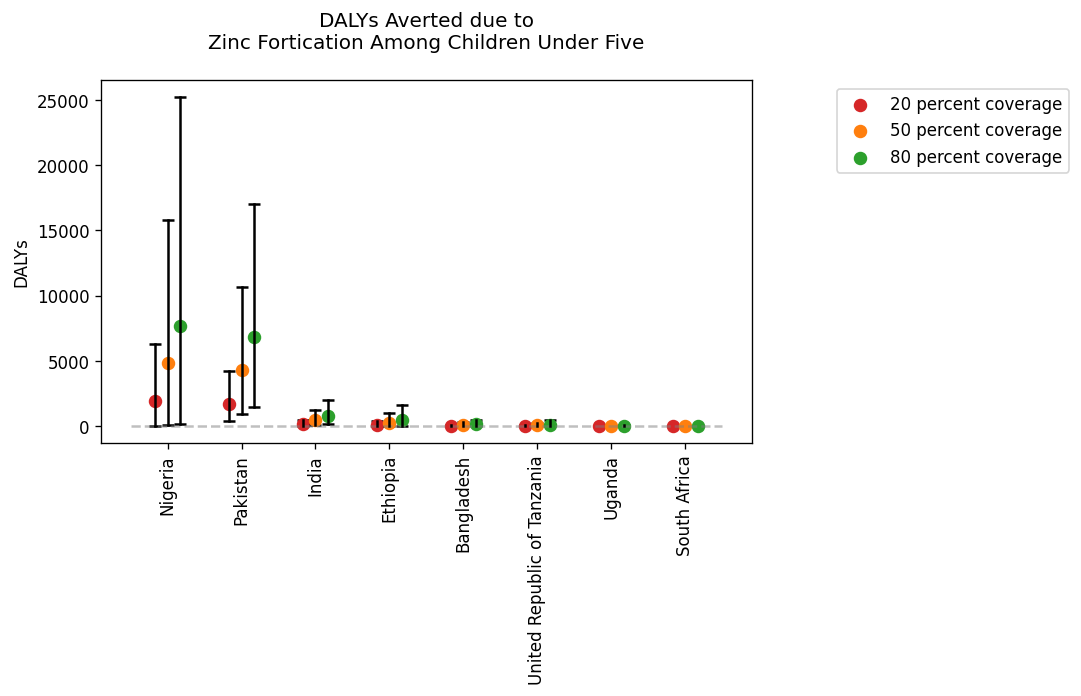

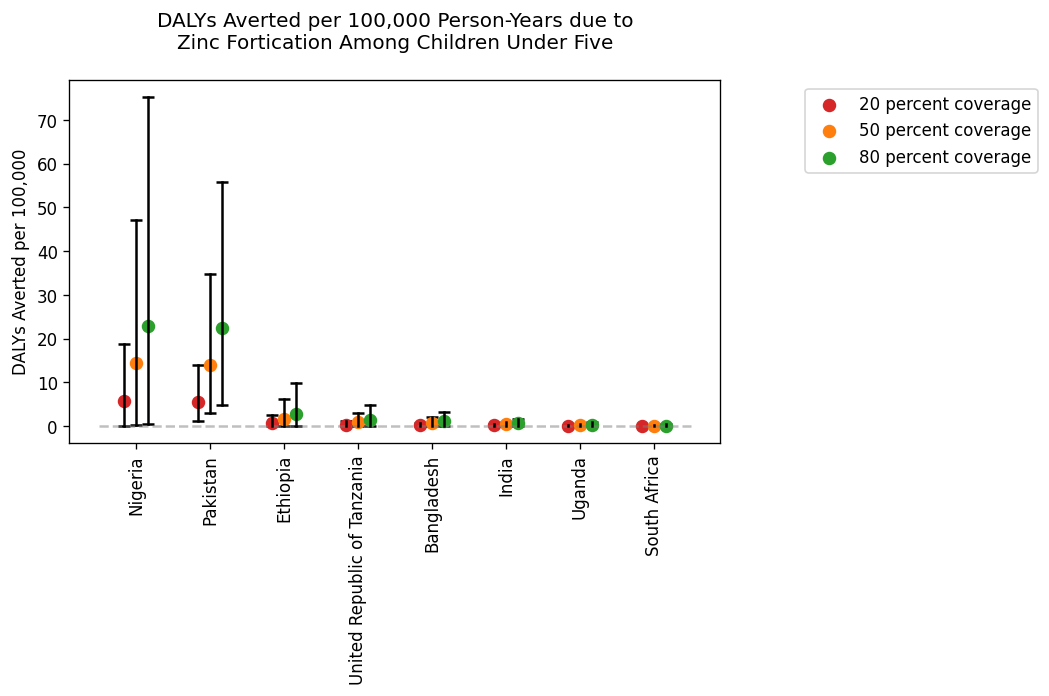

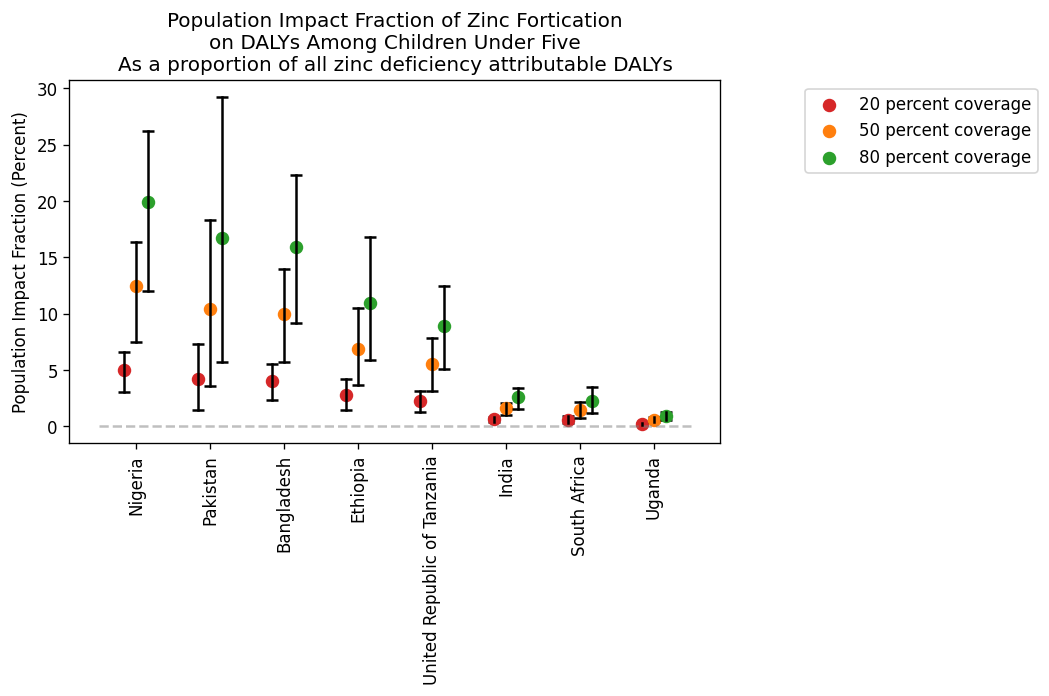

In [31]:
make_dot_plots(zinc_daly_reduction_counts, 'Zinc', 'counts', coverage_levels,"", 'zinc_u5_counts_averted')
make_dot_plots(zinc_daly_reduction_rates, 'Zinc', 'rates', coverage_levels,"",'zinc_u5_rates_averted')
make_dot_plots(zinc_overall_pifs, 'Zinc', 'pifs', coverage_levels,"As a proportion of all zinc deficiency attributable DALYs",
              'zinc_u5_pif')